In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 26 Mar 2018

License:

# Notebook for calculating the relative zinc ion affinity for different models of carbohydrate chains

TODO:


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

# Notes:
## Model descriptions:
# INSERT PDFS

## pK values:
- pK values and the methos are taken from::
    
|  AA | pKa  |
|-----|------|
| ASP | 4.05 |

## mannning parameter:
 - the manning parameter in DMH notes had |lambda|. I changed this to lambda based on https://arxiv.org/pdf/1212.0430.pdf

In [3]:
# input parameters
working_directory = '/home/atarzia/psugars/working_dir/'

In [4]:
os.chdir(working_directory)

In [5]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19# elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854E-12 # vacuum permittivity [CV^-1m^-1]

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854e-12 C V^-1 m^-1


In [11]:
# variables

# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
N = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# ion valency
Z = 2  # zinc 2+
# set pH
PH = 11

surf_area = 2 * np.pi * a * N*Lc + 2 * np.pi * (a ** 2)


print("============= Variables =============")
print("Glucose monomer length =", Lc, "angstrom")
print("Glucose monomers (DP) =", N, "monomers")
print("cylinder radius =", a, "angstrom")
print("cylinder surface area =", surf_area, "angstrom^2")
print("zinc ion valency =", Z)
print("pH =", PH)
print("=====================================")

============= Variables =============
Glucose monomer length = 5 angstrom
Glucose monomers (DP) = 20 monomers
cylinder radius = 5 angstrom
cylinder surface area = 3298.672286269283 angstrom^2
zinc ion valency = 2
pH = 11


In [12]:
func_colors = {"none": 'k', "COO": 'r', "NH2": 'b'}

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for CH3COONa per glucose (max at 3, for 3 OH)
func_content = np.arange(0, 3.1, 0.1)
func_count = func_content * N

# set charge and pka of functionalisations
func_charges = {"COO": -1}#, "NH2": +1, "none": 0}
func_pkas = {"none": 0, "COO": 4, "NH2": 12}

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    if func == 'none':
        partial_charge = 0
    else:
        pka = func_pkas[func]
        charge = func_charges[func]
        partial_charge = calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


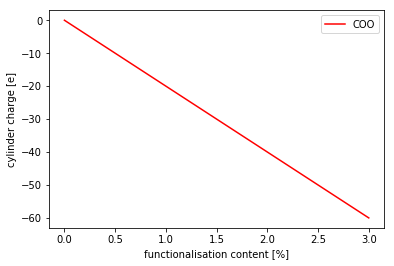

In [13]:
fig, ax = plt.subplots()
for func in func_charges.keys():
    ax.plot(func_content, func_total_charges[func], label=func, c=func_colors[func])

ax.set_xlabel("functionalisation content [%]")
ax.set_ylabel("cylinder charge [e]")
ax.legend()
plt.show()

In [14]:
# Equation 1.3
# bjerrum length
lb = calculate_bjerrum_length(Z)

## In the limit as KAPPA goes to 0

In [15]:
# functions
#def calculate_Rs(Lc, Cs):
#    """
#    Calculate Rs from equation 1.2.
#    
#    Lc = length of cylinder [angstrom]
#    Cs = concentration of carbohydrate [mol/L]
#    
#    """
#    
#    
#    return Rs # in angstrom

def calculate_sigma_of_cylinder(charge, length, radius):
    """
    Calculate surface charge density of cylinder as total charge / surface area of cylinder (Equation 1.7)
    
    charge [e [C]]
    length of cylinder [angstrom]
    radius of cylinder [angstrom]
    
    returns sigma [Cm^-2]
    
    """
    length = length * (10 ** -10) # to m
    radius = radius * (10 ** -10) # to m
    charge = e * charge # to C
    
    area = 2 * np.pi * radius * length + 2 * np.pi * (radius ** 2)
        
    sigma = charge / area
    return sigma # Cm^-2
def calculate_func_charge(charge, pH, pka):
    """
    Calculate the charge probability of a functional group with a given pKa for a given pH.
    """
    ratio = 1 / (1 + 10**(pH - pka))

    if charge == 1:
        return ratio
    else:
        return ratio - 1
def calculate_bjerrum_length(Z):
    """
    Calculate the Bjerrum length for Z valent ion in water from Equation 1.3.
    
    Z = valency of ion [zinc = 2+]
    
    returns lb in angstrom
    """
    top = (Z * e) ** 2
    bottom = 4 * np.pi * E_0 * E_r * KB * T
    
    lb = top / bottom
    lb = lb * (10 ** 10) # to angstrom
    return lb # angstrom   
def calculate_lambda(a, sigma):
    """
    Calculate the line charge density of a cylinder from Equation 1.4
    
    a = radius of cylinder [angstrom]
    sigma = surface charge density [Cm^-2]
    
    returns lambda in Cm^-1
    """
    a = a * (10 ** -10) # to m
    lamb = 2 * np.pi * a * sigma
    return lamb # in Cm^-1
def calculate_manning_parameter(lamb, lb, Z):
    """
    Calculate the manning parameter from Equation 1.5
        
    lamb = lambda = line charge density [Cm^-1]
    lb = bjerrum length [angstrom]
    Z = valency of ion [zinc = 2+]
    
    returns zeta as a unit less value
    
    """
    lb = lb * (10 ** -10) # to m
    
    top = abs(lamb) * lb # in Cm-1 * m = C
    bottom = Z * e # in C
    
    zeta = top / bottom
    
    return zeta
def calculate_zinc_surface_conc(zeta, lb, a):
    """
    Calculate the zinc ion concentration at the surface of the carbohydrate from Equation 1.6
    
    zeta = manning parameter [unit less]
    lb = bjerrum length [angstrom]
    a = radius of cylinder [angstrom]
    
    returns n_plus(a) in mol/L
    
    """
    a = a * (10 ** -10) # to m
    lb = lb * (10 ** -10) # to m
    top = (1 - zeta) ** 2
    bottom = (2 * np.pi * lb * (a ** 2))
    n_plus = top / bottom # in m^-3
    n_plus = n_plus / 1000 # to L^-1
    n_plus = n_plus / NA  # to mol/L
    return n_plus

In [16]:
# in the limit as kappa goes to 0
func_surface_concentration = {}
for func in func_charges.keys():
    print("==========================================")
    print("========", func, "========")
    # calculate surface charge density
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a)
    print("surface charge densities [Cm^-2]:", sigma)
    # Equation 1.4
    # line charge density lambda
    lamb = calculate_lambda(a, sigma)
    print("line charge densities [Cm^-1]:", lamb)
    # Equation 1.5
    zeta = calculate_manning_parameter(lamb, lb, Z)
    print("manning parameters:", zeta)
    # Equation 1.6
    n_plus_surface = calculate_zinc_surface_conc(zeta, lb, a)
    print("surface ion concentraions [mol/L]:", n_plus_surface)
    func_surface_concentration[func] = n_plus_surface
    
    print("==========================================")

======== COO ========
surface charge densities [Cm^-2]: [-0.         -0.00971407 -0.01942814 -0.02914221 -0.03885627 -0.04857034
 -0.05828441 -0.06799848 -0.07771255 -0.08742662 -0.09714069 -0.10685476
 -0.11656882 -0.12628289 -0.13599696 -0.14571103 -0.1554251  -0.16513917
 -0.17485324 -0.18456731 -0.19428137 -0.20399544 -0.21370951 -0.22342358
 -0.23313765 -0.24285172 -0.25256579 -0.26227985 -0.27199392 -0.28170799
 -0.29142206]
line charge densities [Cm^-1]: [-0.00000000e+00 -3.05176469e-11 -6.10352937e-11 -9.15529406e-11
 -1.22070587e-10 -1.52588234e-10 -1.83105881e-10 -2.13623528e-10
 -2.44141175e-10 -2.74658822e-10 -3.05176469e-10 -3.35694115e-10
 -3.66211762e-10 -3.96729409e-10 -4.27247056e-10 -4.57764703e-10
 -4.88282350e-10 -5.18799997e-10 -5.49317643e-10 -5.79835290e-10
 -6.10352937e-10 -6.40870584e-10 -6.71388231e-10 -7.01905878e-10
 -7.32423524e-10 -7.62941171e-10 -7.93458818e-10 -8.23976465e-10
 -8.54494112e-10 -8.85011759e-10 -9.15529406e-10]
manning parameters: [0.      

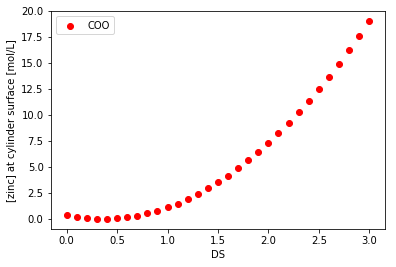

In [18]:
fig, ax = plt.subplots()
for func in func_charges.keys():
    ax.scatter(func_content, func_surface_concentration[func], label=func, c=func_colors[func])

ax.set_xlabel("DS")
ax.set_ylabel("[zinc] at cylinder surface [mol/L]")
ax.legend()
plt.savefig('surface_conc_vs_DS.pdf', dpi=300, bbox_inches='tight')
plt.show()

#  22/4/18:
## Low charge density - low salt.
Working from:
- https://arxiv.org/abs/cond-mat/9701067
- https://onlinelibrary-wiley-com.proxy.library.adelaide.edu.au/doi/abs/10.1002/bip.360230209

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%run ./expressions.py

In [29]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19 # elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854E-12 # vacuum permittivity [CV^-1m^-1]
PI = np.pi

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

## variables ##
# salt concs (1 - Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = -1 * 2  # zinc 2+
Z2 = -1 * -1  # co-ion
# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
N = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# set pH
PH = 11
# get cylinder surface area
surf_area = 2 * np.pi * a * N*Lc + 2 * np.pi * (a ** 2)

# radial positions from surface of cylinder (angstrom)
r_ = np.linspace(0, 20, 100)
# vary the degree of substitution
DS = np.linspace(0.1, 1, 5)
# set the average distance between charges on cylinder
# from DS
# in angstrom
b_ = Lc / DS

# set plto colours
colour = cm.coolwarm(np.linspace(0.5, 1, len(DS)))

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854e-12 C V^-1 m^-1


In [30]:
# calculate bjerrum length
# in angstrom
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')

lb = 28.587994507059786 angstrom
lb = 2.8587994507059787e-09 m


In [31]:
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I / 1000  # molecules / m3
print('I =', I_m, 'm^-3')

I = 0.12 mol/L
I = 7.226569028399999e+19 m^-3


In [32]:
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa^2 =', kappasq * (10 ** -20), 'angstrom^-2')

# reduced coordinates (unitless)
kr_ = np.sqrt(kappasq) * (10 ** -10) * r_

kappa^2 = 5192251316240.971 m^-2
kappa^2 = 5.19225131624097e-08 angstrom^-2


In [33]:
# calculate zeta = lb / b (from https://arxiv.org/abs/cond-mat/9701067)
# b is the average spacing between charges on the cylinder 
zeta_ = lb / b_ # angstrom / angstrom!

In [34]:
# calculate reduced potential using the DH solution (https://arxiv.org/abs/cond-mat/9701067 E2.1)
# - as a function of b (distance between charges) - multiple values used
ys = calculate_y(zeta_, kr_)

In [35]:
# calculate SI potential (psi(r))
psi_ = []
for i in ys:
    psi = i * KB * T / e # Volts
    psi_.append(psi * 1000) # mV

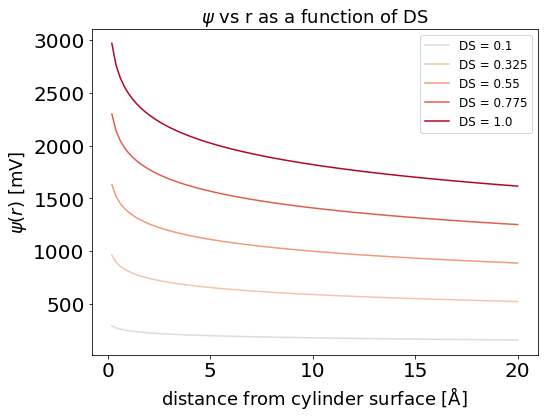

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, ds in enumerate(DS):
    ax.plot(r_, psi_[i], c=colour[i], label='DS = '+str(DS[i]))

ax.set_title(r'$\psi$ vs r as a function of DS', fontsize=18)
ax.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
ax.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig('surface_conc_vs_DS.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# calculate concentration of zinc ions at the surface (r=0) from psi(r)
# using boltzmann equation
# c+/- = c+/-(bulk) * exp[-/+Z+/i*psi]
zinc_conc = []
zinc_counter_conc = []
for i in psi_:
    surf_pot = np.average(i[1:4]) / 1000 # in V
    z_c = calculate_conc(surf_pot, salt1_conc, Z1)
    z_counter_c = calculate_conc(surf_pot, salt2_conc, Z2)
    
    zinc_conc.append(z_c)
    zinc_counter_conc.append(z_counter_c)

In [41]:
print(zinc_conc)

[110334759.73761469, 1.923889696854399e+29, 3.35465593477939e+50, 5.849460319451251e+71, 1.0199611135704418e+93]


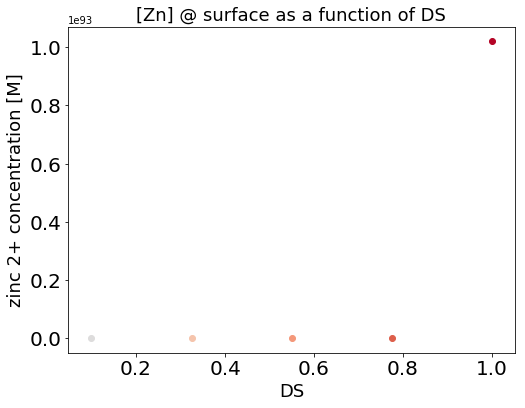

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, ds in enumerate(DS):
    ax.scatter(ds, zinc_conc[i], c=colour[i], label='DS = '+str(DS[i]))

ax.set_title(r'[Zn] @ surface as a function of DS', fontsize=18)
ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("zinc 2+ concentration [M]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig('surface_conc_vs_DS.pdf', dpi=300, bbox_inches='tight')
plt.show()

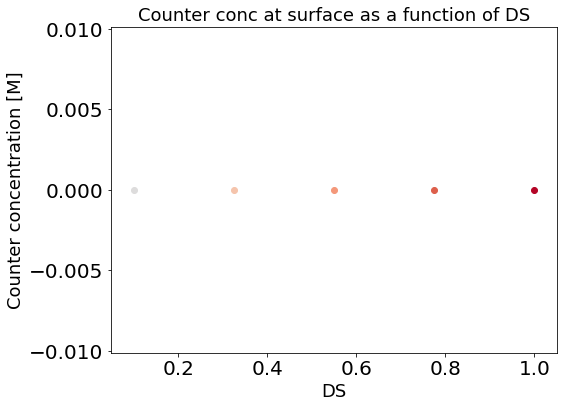

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, ds in enumerate(DS):
    ax.scatter(ds, zinc_counter_conc[i], c=colour[i], label='DS = '+str(DS[i]))

ax.set_title(r'[Zn counter ion] @ surface as a function of DS', fontsize=18)
ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("concentration [M]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig('surface_conc_vs_DS.pdf', dpi=300, bbox_inches='tight')
plt.show()